https://pennylane.ai/qml/demos/tutorial_vqe/

Simulation time Pennylane: 0.816 segons

Meva: 1.9 segons

In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:
import jax
import jaxlib

Number of qubits =  4
The Hamiltonian is    (-0.24274501260941417) [Z2]
+ (-0.2427450126094141) [Z3]
+ (-0.04207255194743964) [I0]
+ (0.17771358229091744) [Z1]
+ (0.17771358229091758) [Z0]
+ (0.12293330449299363) [Z0 Z2]
+ (0.12293330449299363) [Z1 Z3]
+ (0.1676833885560136) [Z0 Z3]
+ (0.1676833885560136) [Z1 Z2]
+ (0.1705975927683681) [Z0 Z1]
+ (0.17627661394181804) [Z2 Z3]
+ (-0.04475008406301998) [Y0 Y1 X2 X3]
+ (-0.04475008406301998) [X0 X1 Y2 Y3]
+ (0.04475008406301998) [Y0 X1 X2 Y3]
+ (0.04475008406301998) [X0 Y1 Y2 X3]
[1 1 0 0]


c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Step = 0,  Energy = -1.12799978 Ha
Step = 2,  Energy = -1.13466251 Ha
Step = 4,  Energy = -1.13590598 Ha
Step = 6,  Energy = -1.13613665 Ha
Step = 8,  Energy = -1.13617945 Ha
Step = 10,  Energy = -1.13618731 Ha
Step = 12,  Energy = -1.13618886 Ha

Final value of the ground-state energy = -1.13618886 Ha

Optimal value of the circuit parameter = 0.2089


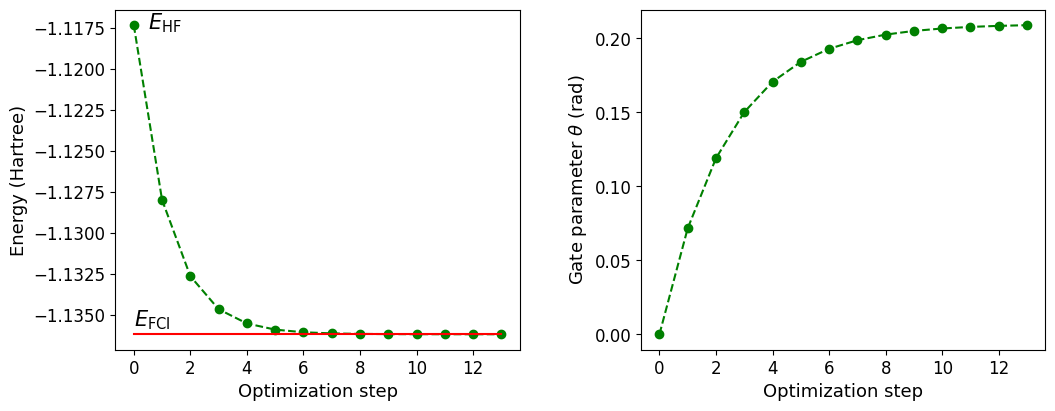

In [3]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])


H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

dev = qml.device("lightning.qubit", wires=qubits)

electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

@qml.qnode(dev)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

def cost_fn(param):
    return circuit(param, wires=range(qubits))

import optax

max_iterations = 100
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

https://pennylane.ai/qml/demos/tutorial_circuit_compilation/

Simulation time: 1.4 segons


Meva: 0.5 segons :))



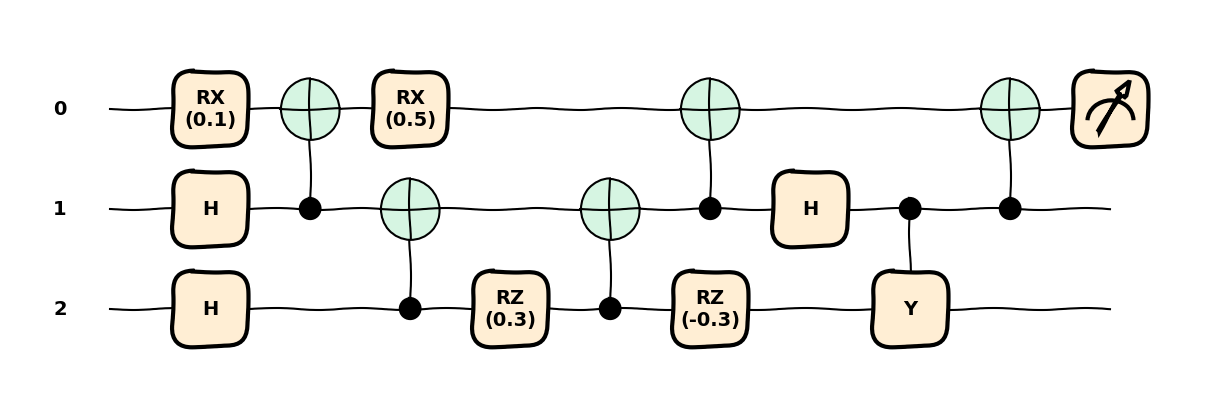

In [4]:
from functools import partial
import pennylane as qml
import matplotlib.pyplot as plt

dev = qml.device("default.qubit", wires=3)


def circuit(angles):
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RX(angles[0], 0)
    qml.CNOT(wires=[1, 0])
    qml.CNOT(wires=[2, 1])
    qml.RX(angles[2], wires=0)
    qml.RZ(angles[1], wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RZ(-angles[1], wires=2)
    qml.CNOT(wires=[1, 0])
    qml.Hadamard(wires=1)
    qml.CY(wires=[1, 2])
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(wires=0))


angles = [0.1, 0.3, 0.5]
qnode = qml.QNode(circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(angles)
plt.show()

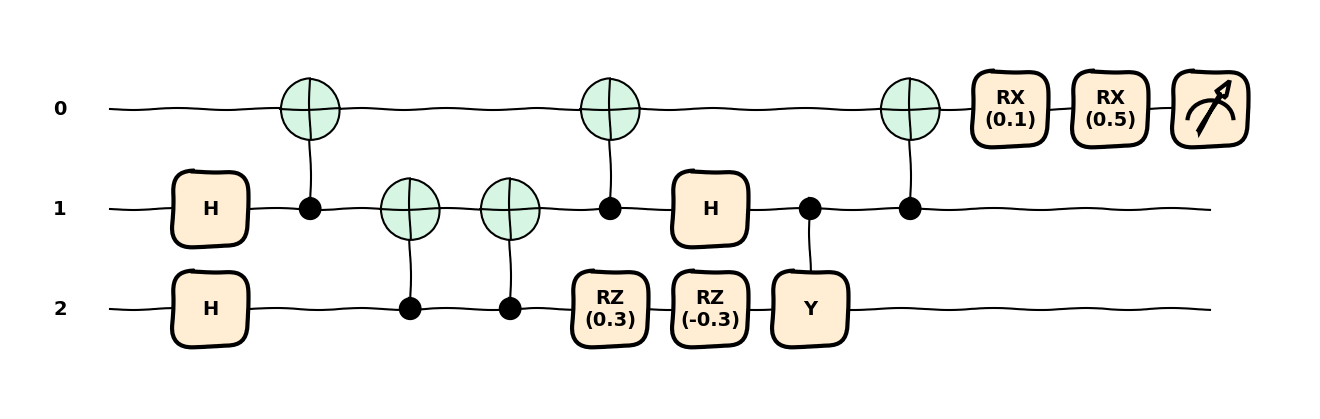

In [5]:
commuted_circuit = qml.transforms.commute_controlled(circuit, direction="right")

qnode = qml.QNode(commuted_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(angles)
plt.show()

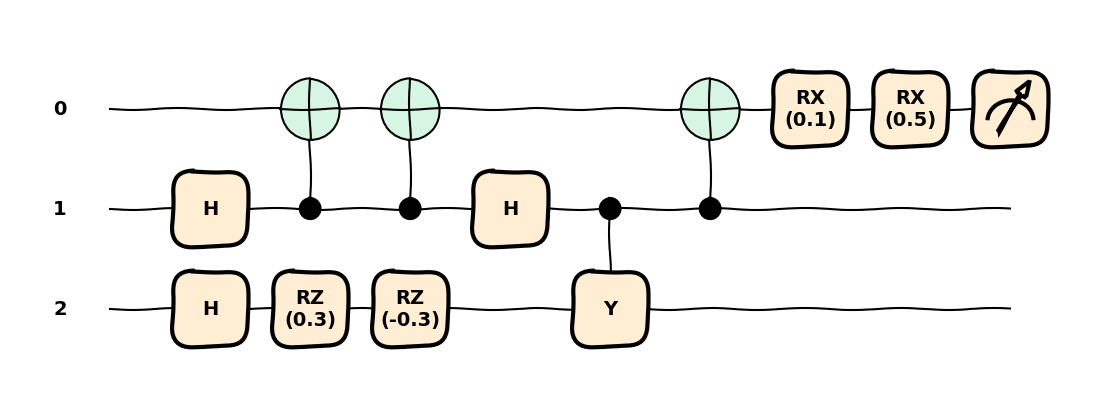

In [6]:
cancelled_circuit = qml.transforms.cancel_inverses(commuted_circuit)


qnode = qml.QNode(cancelled_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(angles)
plt.show()

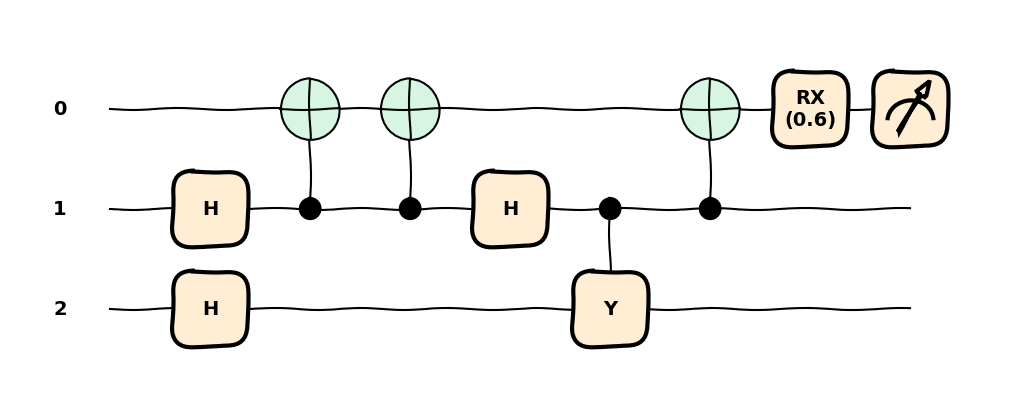

In [7]:
@qml.qnode(dev)
@partial(qml.transforms.merge_rotations, atol=1e-8, include_gates=None)
@qml.transforms.cancel_inverses
@partial(qml.transforms.commute_controlled, direction="right")
def q_fun(angles):
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RX(angles[0], 0)
    qml.CNOT(wires=[1, 0])
    qml.CNOT(wires=[2, 1])
    qml.RX(angles[2], wires=0)
    qml.RZ(angles[1], wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RZ(-angles[1], wires=2)
    qml.CNOT(wires=[1, 0])
    qml.Hadamard(wires=1)
    qml.CY(wires=[1, 2])
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(wires=0))


qml.draw_mpl(q_fun, decimals=1, style="sketch")(angles)
plt.show()

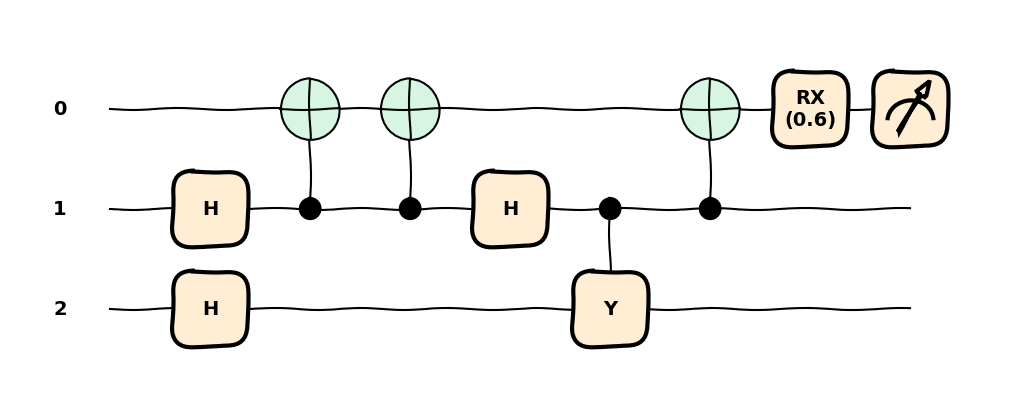

In [8]:
compiled_circuit = qml.compile(circuit)

qnode = qml.QNode(compiled_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(angles)
plt.show()

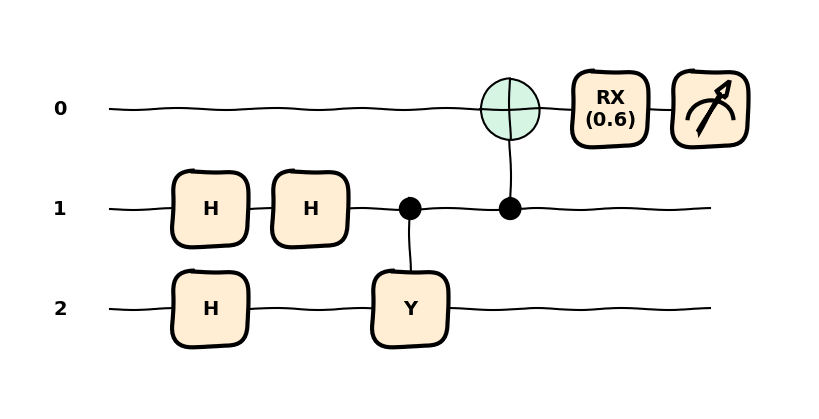

In [9]:
compiled_circuit = qml.compile(circuit, num_passes=2)

qnode = qml.QNode(compiled_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(angles)
plt.show()

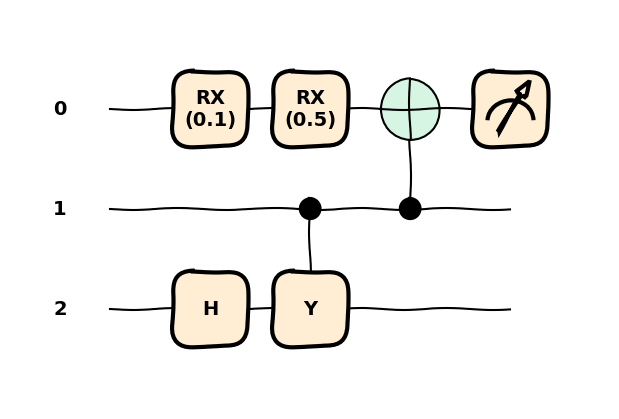

In [10]:
compiled_circuit = qml.compile(
    circuit,
    pipeline=[
        partial(qml.transforms.commute_controlled, direction="left"),  # Opposite direction
        partial(qml.transforms.merge_rotations, include_gates=["RZ"]),  # Different threshold
        qml.transforms.cancel_inverses,  # Cancel inverses after rotations
    ],
    num_passes=3,
)

qnode = qml.QNode(compiled_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(angles)
plt.show()

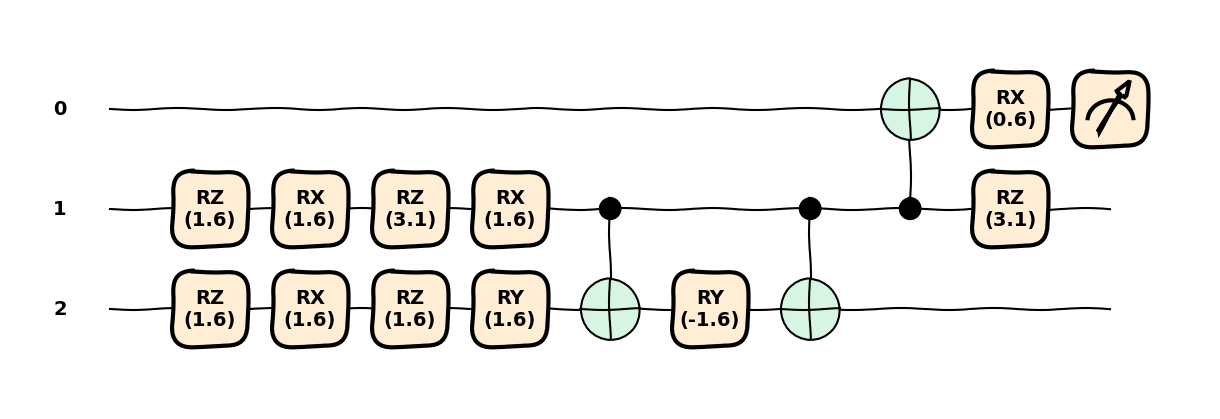

In [11]:
compiled_circuit = qml.compile(circuit, basis_set=["CNOT", "RX", "RY", "RZ"], num_passes=2)

qnode = qml.QNode(compiled_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(angles)
plt.show()

https://pennylane.ai/qml/demos/tutorial_quantum_chemistry/


Simulation time: 16.33 segons

Meva: 11.3 segons :))

In [13]:
from pennylane import qchem

symbols = ["H", "O", "H"]
coordinates = np.array([-0.0399, -0.0038, 0.0, 1.5780, 0.8540, 0.0, 2.7909, -0.5159, 0.0])

H, qubits = qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits: {:}".format(qubits))
print("Qubit Hamiltonian")
print(H)

charge = 0
multiplicity = 1
basis_set = "sto-3g"

electrons = 10
orbitals = 7
core, active = qchem.active_space(electrons, orbitals, active_electrons=4, active_orbitals=4)
print("List of core orbitals: {:}".format(core))
print("List of active orbitals: {:}".format(active))
print("Number of qubits: {:}".format(2 * len(active)))

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=charge,
    mult=multiplicity,
    basis=basis_set,
    active_electrons=4,
    active_orbitals=4,
)

print("Number of qubits required to perform quantum simulations: {:}".format(qubits))
print("Hamiltonian of the water molecule")
print(H)



Number of qubits: 14
Qubit Hamiltonian
  (-46.46418145372073) [I0]
+ (0.7829994516459415) [Z10]
+ (0.7829994516459415) [Z11]
+ (0.8084692666035469) [Z12]
+ (0.8084692666035469) [Z13]
+ (1.2033931869636245) [Z4]
+ (1.2033931869636245) [Z5]
+ (1.3096450222225868) [Z6]
+ (1.3096450222225868) [Z7]
+ (1.369342587737267) [Z9]
+ (1.3693425877372676) [Z8]
+ (1.6538777936362252) [Z2]
+ (1.6538777936362263) [Z3]
+ (12.412625771378286) [Z0]
+ (12.412625771378286) [Z1]
+ (-0.10433156375823831) [Y0 Y2]
+ (-0.10433156375823831) [X0 X2]
+ (-0.003277137061425788) [Y1 Y3]
+ (-0.003277137061425788) [X1 X3]
+ (-0.00016021881405513944) [Y10 Y12]
+ (-0.00016021881405513944) [X10 X12]
+ (-3.624170646027191e-05) [Y5 Y7]
+ (-3.624170646027191e-05) [X5 X7]
+ (-3.131026528386418e-05) [Y2 Y4]
+ (-3.131026528386418e-05) [X2 X4]
+ (-1.1598885879691035e-05) [Y4 Y6]
+ (-1.1598885879691035e-05) [X4 X6]
+ (1.5169182227870045e-05) [Y3 Y5]
+ (1.5169182227870045e-05) [X3 X5]
+ (0.0001555442409848229) [Y11 Y13]
+ (0.00015